In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Handling and Processing
import pandas as pd
import numpy as np
import itertools

# Diagram Drawing
!pip install mermaid-py > /null
import mermaid as md
from mermaid.graph import Graph

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Analysis
import string
import re
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from tqdm import tqdm
from nltk import ngrams
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.10 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [3]:
TRAIN_LIST = ["original", "daigt", "prompt7", "daigt_ex", "daigt_pr", "falcon", 
              "mixtral", "claude", "palm", "persuade", "mistral7B", "augmented", "daigt-v4"]

In [4]:
data_dic = {}

In [5]:
# original competition data
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
df_org = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
df_org["source"] = ["original"] * len(df_org)
data_dic["original"] = df_org.rename(columns={'generated': 'label'})

In [6]:
# DAIGT v2 train dataset
df = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
df["source"] = ["daigt"] * len(df)
data_dic["daigt"] = df.rename(columns={"prompt_name": "prompt_id"})

In [7]:
# DAIGT external dataset
df = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")
df_man = df.loc[:, ["text", "instructions"]]
df_man["label"] = [0] * len(df_man)
df_ai = df.loc[:, ["source_text", "instructions"]]
df_ai = df_ai.rename(columns={'source_text': 'text'})
df_ai["label"] = [1] * len(df_ai)
df = pd.concat([df_man, df_ai], join='inner')
df["source"] = ["daigt_ex"] * len(df)
data_dic["daigt_ex"] = df.rename(columns={"instructions": "prompt_id"})

In [8]:
# DAIGT proper train dataset
df = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv")
df["source"] = ["daigt_pr"] * len(df)
data_dic["daigt_pr"] = df.rename(columns={"prompt": "prompt_id"})

In [9]:
# LLM 7 prompt training dataset
df = pd.read_csv("/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v2.csv")
df["source"] = ["prompt7"] * len(df)
df["prompt_id"] = [0] * len(df)
data_dic["prompt7"] = df.copy()

In [10]:
# DAIGT data llama70b and falcon180b dataset
df = pd.read_csv("/kaggle/input/daigt-data-llama-70b-and-falcon180b/llama_falcon_v3.csv")
df = df.rename(columns={'generated': 'label'})
df["source"] = ["falcon"] * len(df)
data_dic["falcon"] = df.rename(columns={"prompt_name": "prompt_id"})

In [11]:
# Mixtral 87b crafted essays dataset
df = pd.read_csv("/kaggle/input/4k-mixtral87b-crafted-essays-for-detect-ai-comp/Mixtral8x7b_4k_essays_for_DetectAIGeneratedTextCompetition.csv")
df["label"] = [1] * len(df)
df["source"] = ["mixtral"] * len(df)
data_dic["mixtral"] = df.rename(columns={'AI_Essay': 'text'})

In [12]:
# Hello claude 1000 essays dataset
df = pd.read_csv("/kaggle/input/hello-claude-1000-essays-from-anthropic/persuade15_claude_instant1.csv")
df["label"] = [1] * len(df)
df["source"] = ["claude"] * len(df)
data_dic["claude"] = df.rename(columns={'essay_text': 'text'})

In [13]:
# Google PaLM dataset
df = pd.read_csv("/kaggle/input/llm-generated-essay-using-palm-from-google-gen-ai/LLM_generated_essay_PaLM.csv")
df["source"] = ["palm"] * len(df)
data_dic["palm"] = df.rename(columns={'generated': 'label'})

In [14]:
# Persuade copus
df = pd.read_csv("/kaggle/input/persaude-corpus-2/persuade_2.0_human_scores_demo_id_github.csv")
df["label"] = [1] * len(df)
df = df.rename(columns={"prompt_name": "prompt_id"})
df["source"] = ["persuade"] * len(df)
df = df.rename(columns={'prompt_name': 'prompt_id'})
data_dic["persuade"] = df.rename(columns={'full_text': 'text'})

In [15]:
# Mistral7B
df = pd.read_csv("/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7_15_percent_corruption.csv")
data_dic["mistral7B"] = df.rename(columns={'generated': 'label'})

In [16]:
# Augmented data for LLM detect
df_test = pd.read_csv("/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_test.csv")
df_train = pd.read_csv("/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_train.csv")
df = pd.concat([df_test, df_train], join="inner")
df["source"] = ["augmented"] * len(df)
df["prompt_id"] = [0] * len(df)
data_dic["augmented"] = df.copy()

In [17]:
# DAIGT-v4
df = pd.read_csv("/kaggle/input/daigt-v4-train-dataset/train_v4_drcat_01.csv")
data_dic["daigt-v4"] = df.rename(columns={'prompt_name': 'prompt_id'})

In [18]:
# Data aggregation
def aggregate_data(target_list):
    data_list = []
    for target in target_list:
        data_list.append(data_dic[target])
    out_data = pd.concat(data_list, join='inner')
    out_data = out_data.drop_duplicates(subset=["text"])
    out_data.reset_index(drop=True, inplace=True)
    return out_data

In [19]:
aggregated_train = aggregate_data(TRAIN_LIST)

In [20]:
aggregated_train

,prompt_id,text,label
0,0,Cars. Cars have been around since they became ...,0.0
1,0,Transportation is a large necessity in most co...,0.0
2,0,"""America's love affair with it's vehicles seem...",0.0
3,0,How often do you ride in a car? Do you drive a...,0.0
4,0,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...,...
527715,Grades for extracurricular activities,I am writing you today to disagree with your t...,1.0
527716,Grades for extracurricular activities,"Dear Principal,\n\nIn conclusion, I would obse...",1.0
527717,Grades for extracurricular activities,"Dear Mrs. Principal,\n\nin these kinds of cons...",1.0
527718,Grades for extracurricular activities,I enjoyed Form five and excitedly ex claims ed...,1.0


In [25]:
# Show data prifiles
print("Data profiles:\n")
print("Loaded datasets:")
size_list = []
node_dic = {}
for target in data_dic.keys():
    size_list.append([target, len(data_dic[target])])
    node_dic[target] = target + ":" + str(len(data_dic[target]))
df = pd.DataFrame(size_list,columns=["dataet", "size"])
display(df)
print("Total size of loaded datasets: ", df["size"].sum())
print("\n\n")
print("Aggregated datasets: ", TRAIN_LIST)
print("Unique records in the aggregated datasets = ", len(aggregated_train))
print("\n\n")
print("Aggregated datasets sample:")
display(aggregated_train.head(3))

Data profiles:

Loaded datasets:


,dataet,size
0,original,1378
1,daigt,44868
2,daigt_ex,4842
3,daigt_pr,44206
4,prompt7,17251
5,falcon,7000
6,mixtral,3865
7,claude,1000
8,palm,1384
9,persuade,25996


Total size of loaded datasets:  663827



Aggregated datasets:  ['original', 'daigt', 'prompt7', 'daigt_ex', 'daigt_pr', 'falcon', 'mixtral', 'claude', 'palm', 'persuade', 'mistral7B', 'augmented', 'daigt-v4']
Unique records in the aggregated datasets =  527720



Aggregated datasets sample:


,prompt_id,text,label
0,0,Cars. Cars have been around since they became ...,0.0
1,0,Transportation is a large necessity in most co...,0.0
2,0,"""America's love affair with it's vehicles seem...",0.0


#### Comparing AI and Human Essays

In [26]:
df_ai = aggregated_train[aggregated_train["label"] == 1]
df_human = aggregated_train[aggregated_train["label"] == 0]
print("---------------------------------------------- : AI text sample : ----------------------------------------------")
print(df_ai.iloc[0]["text"])
print("\n\n")
print("---------------------------------------------- : Human text sample : ----------------------------------------------")
print(df_human.iloc[0]["text"])

---------------------------------------------- : AI text sample : ----------------------------------------------
This essay will analyze, discuss and prove one reason in favor of keeping the Electoral College in the United States for its presidential elections. One of the reasons to keep the electoral college is that it is better for smaller, more rural states to have more influence as opposed to larger metropolitan areas that have large populations. The electors from these states are granted two votes each. Those from larger, more populated areas are granted just one vote each. Smaller states tend to hold significant power because their two votes for president and vice president add up more than the votes of larger states that have many electors. This is because of the split of the electoral votes. Some argue that electors are not bound to vote for the candidate who won the most votes nationally. They do not have to vote for their own state's nominee unless their state has a winner ta

In [27]:
# Functions for Bar Graph

def add_value_label(plt, x_list, y_list):
    for i in range(len(x_list)):
        plt.annotate(y_list[i], (i, y_list[i]), ha="center")

def show_bar_graph(labels, values, title, ylabel):
    plt.bar(labels, values, color=["coral", "lightgreen"])
    add_value_label(plt, labels, values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

In [29]:
# Functions for Histograms

def show_histograms(df_ai, df_human, column):
    xmin = min(df_ai[column].min(), df_human[column].min())
    xmax = max(df_ai[column].max(), df_human[column].max())
    width = (xmax - xmin) / 100
    sns.histplot(df_ai[column], kde=False, color="coral", bins=np.arange(xmin, xmax, width))
    sns.histplot(df_human[column], kde=False, color="lightgreen", bins=np.arange(xmin, xmax, width))
    plt.legend(['ai', 'human'])
    plt.title('Overlaid histogram for {}'.format(column))
    plt.show()

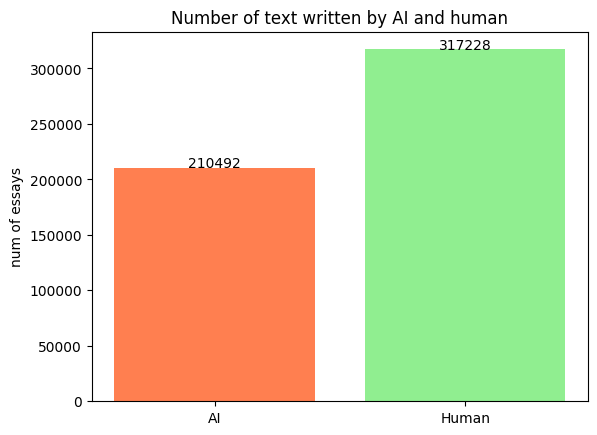

In [28]:
# Number of text written by AI and human
labels = ['AI', 'Human']
values = [len(df_ai), len(df_human)]

show_bar_graph(labels, values, "Number of text written by AI and human", "num of essays")

AI text length samples:


,prompt_id,text,label,text_len
704,1,"This essay will analyze, discuss and prove one...",1.0,1356
740,1,I strongly believe that the Electoral College ...,1.0,1500
1262,0,"Limiting car use causes pollution, increases c...",1.0,1797



Human text length samples:


,prompt_id,text,label,text_len
0,0,Cars. Cars have been around since they became ...,0.0,3289
1,0,Transportation is a large necessity in most co...,0.0,2738
2,0,"""America's love affair with it's vehicles seem...",0.0,4428


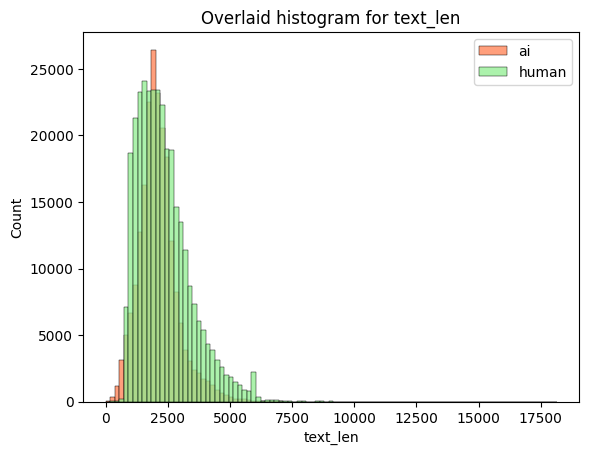

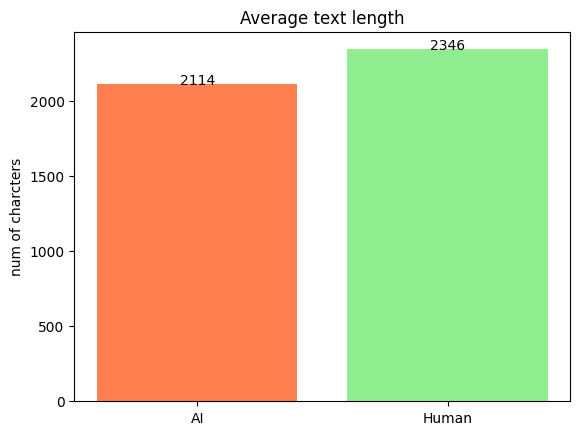

In [30]:
# Histogram for text length
df_ai.loc[:,["text_len"]] = df_ai["text"].apply(len)
df_human.loc[:,["text_len"]] = df_human["text"].apply(len)

print("AI text length samples:")
display(df_ai.head(3))
print()
print("Human text length samples:")
display(df_human.head(3))

show_histograms(df_ai, df_human, "text_len")

labels = ['AI', 'Human']
values = [int(df_ai["text_len"].sum()/len(df_ai)), int(df_human["text_len"].sum()/len(df_human))]

show_bar_graph(labels, values, "Average text length", "num of charcters")

In [31]:
def get_unique_ngrams(df, n):
    unique_ngrams = set()
    ngram_freq = {}
    for text in df['text']:
        words = text.lower().split()  # Convert to lowercase and split into words
        words = [word.strip(string.punctuation) for word in words]
        ngrams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
        unique_ngrams.update(set(ngrams))
        for ngram in ngrams:
            if ngram in ngram_freq.keys():
                ngram_freq[ngram] += 1
            else:
                ngram_freq[ngram] = 1
    return unique_ngrams, ngram_freq


def display_dic(dic, columns, n):
    sorted_dic = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(sorted_dic, columns=columns)
    display(df.head(n))
    return df


def show_unique_ngrams(n):
    unique_ngrams_ai, ngram_freq_ai = get_unique_ngrams(df_ai, n)
    unique_ngrams_human, ngram_freq_human = get_unique_ngrams(df_human, n)

    # Bar graph of unique words
    labels = ['AI', 'Human']
    values = [len(unique_ngrams_ai), len(unique_ngrams_human)]
    show_bar_graph(labels, values, f"Unique {n}-grams used by AI and human", "n-grams")

    ngrams_only_ai = set(unique_ngrams_ai) - set(unique_ngrams_human)
    ngram_freq_only_ai = {key: ngram_freq_ai[key] for key in ngram_freq_ai.keys() if key in ngrams_only_ai}
    ngrams_only_human = set(unique_ngrams_human) - set(unique_ngrams_ai)
    ngram_freq_only_human = {key: ngram_freq_human[key] for key in ngram_freq_human.keys() if key in ngrams_only_human}

    print(f"Top 10 {n}-grams only used by ai:")
    top_ngrams_ai = display_dic(ngram_freq_only_ai, [f"{n}-gram", "freq"], 10)
    print()
    print(f"Top 10 {n}-grams only used by human:")
    top_ngrams_human = display_dic(ngram_freq_only_human, [f"{n}-gram", "freq"], 10)
    return top_ngrams_ai, top_ngrams_human



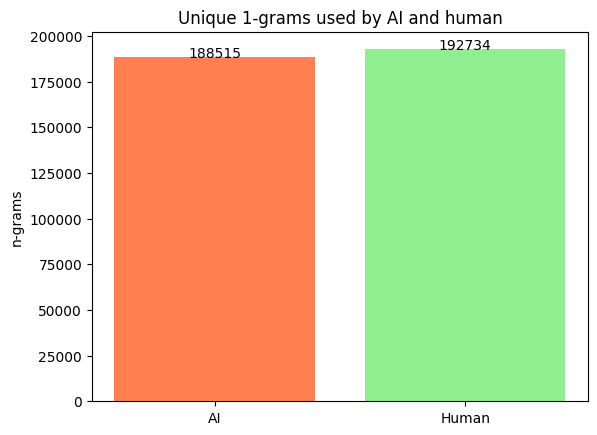

Top 10 1-grams only used by ai:


,1-gram,freq
0,–,4098
1,hillary,3901
2,😅,2773
3,oxides,2522
4,🤔,2348
5,biteable,2222
6,symmetrical,2080
7,😃,1646
8,don’t,1607
9,one’s,1491



Top 10 1-grams only used by human:


,1-gram,freq
0,gavin,5685
1,unrwa,5037
2,blimplike,1916
3,afl,1259
4,mesalandforms,872
5,edgarsnyder,775
6,,708
7,vaughn's,659
8,¨,563
9,palpabraeus,533


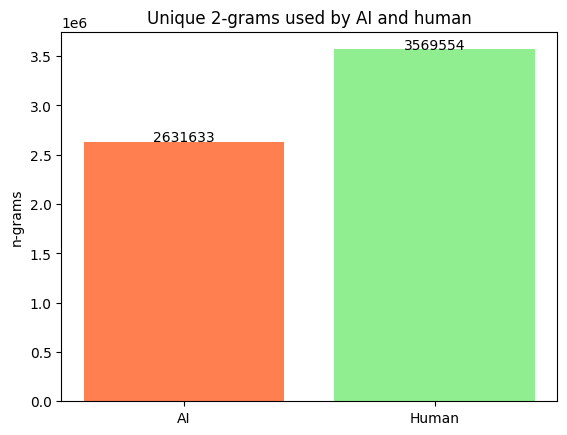

Top 10 2-grams only used by ai:


,2-gram,freq
0,university education,8166
1,like super,6548
2,judge richard,6338
3,geological processes,5524
4,respiratory problems,5401
5,address city,5385
6,state zip,5189
7,valuable insights,5038
8,senator's name,4646
9,sustainable future,4563



Top 10 2-grams only used by human:


,2-gram,freq
0,luke merger,3425
1,huang predicts,2759
2,the unrwa,2741
3,team snapped,2535
4,over colonia,2415
5,anxious web,2266
6,on paragraph,2047
7,paul beckman,2030
8,its self,1958
9,pop icon,1934


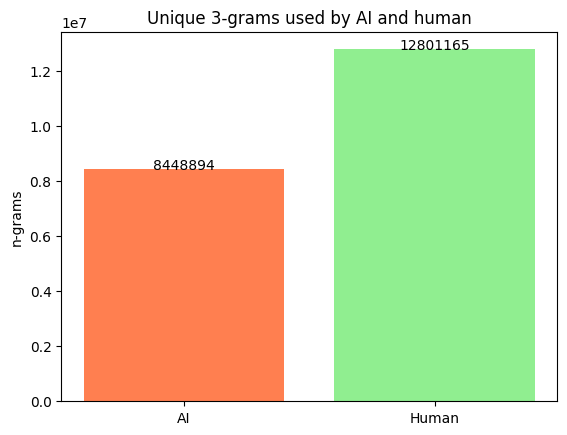

Top 10 3-grams only used by ai:


,3-gram,freq
0,sincerely your name,16549
1,writing to express,11987
2,today to express,6605
3,express my support,6365
4,judge richard a,5887
5,address city state,5267
6,city state zip,5173
7,support for abolishing,5092
8,a tour guide,5080
9,of our democratic,4469



Top 10 3-grams only used by human:


,3-gram,freq
0,snapped a picture,2947
1,main and his,2528
2,dr huang predicts,2484
3,team snapped a,2259
4,of anxious web,2079
5,anxious web surfers,2064
6,thousands of anxious,2057
7,flew over colonia,2040
8,dr paul beckman,1890
9,are the clouds,1808


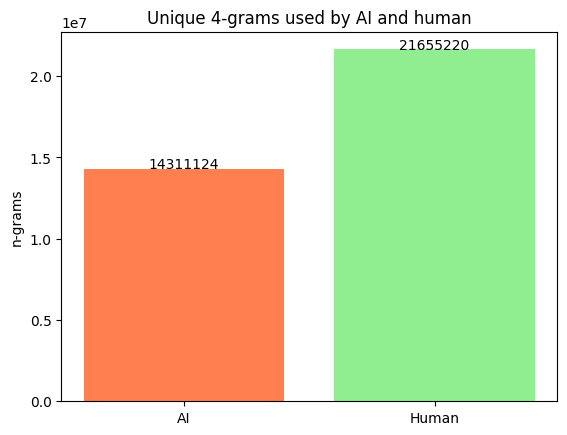

Top 10 4-grams only used by ai:


,4-gram,freq
0,writing to express my,11550
1,am writing to express,11164
2,ensures that the president,9535
3,you today to express,6478
4,today to express my,6341
5,express my support for,6180
6,to express my support,6056
7,to reduce traffic congestion,5686
8,college and electing the,5180
9,name i am writing,5094



Top 10 4-grams only used by human:


,4-gram,freq
0,the text it states,2328
1,been the most earthlike,2271
2,team snapped a picture,2164
3,snapped a picture ten,2127
4,people of other countries,2104
5,michael main and his,2025
6,aware of people of,1938
7,anxious web surfers were,1932
8,of people of other,1910
9,still has some features,1907


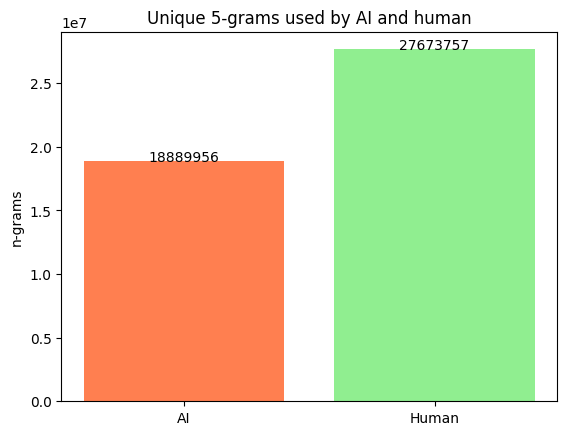

Top 10 5-grams only used by ai:


,5-gram,freq
0,i am writing to express,11154
1,am writing to express my,10954
2,that the president is elected,9061
3,to you today to express,6455
4,you today to express my,6270
5,ensures that the president is,6116
6,to express my support for,5943
7,the electoral college and electing,5278
8,electoral college and electing the,5180
9,college and electing the president,5178



Top 10 5-grams only used by human:


,5-gram,freq
0,been the most earthlike planet,2162
1,in the text it states,2047
2,snapped a picture ten times,2021
3,have been the most earthlike,1937
4,of other countries and their,1912
5,people of other countries and,1902
6,of people of other countries,1856
7,of anxious web surfers were,1825
8,anxious web surfers were waiting,1817
9,aware of people of other,1783


In [32]:
max_gram = 5
top_ngram_dic = {}
top_ngram_dic["ai"] = {}
top_ngram_dic["human"] = {}
for n in range(1,max_gram + 1):
    only_ai, only_human = show_unique_ngrams(n)
    top_ngram_dic["ai"][str(n)] = only_ai
    top_ngram_dic["human"][str(n)] = only_human
    print("\n\n")

In [33]:
df_vis = aggregated_train.copy()

In [34]:
# Get tokens
tqdm.pandas(desc="Tokenizing Text")
df_vis['tokens'] = df_vis['text'].progress_apply(lambda x: word_tokenize(str(x)))
df_vis['num_characters'] = df_vis['text'].progress_apply(lambda x: len(str(x)))
df_vis['num_words'] = df_vis['tokens'].progress_apply(lambda tokens: len(tokens))
df_vis['num_unique_words'] = df_vis['tokens'].progress_apply(lambda x: len(set(x)))
df_vis['num_sentences'] = df_vis['text'].progress_apply(lambda x: len(sent_tokenize(str(x))))

Tokenizing Text: 100%|██████████| 527720/527720 [08:35<00:00, 1023.92it/s]


In [35]:
df_vis.to_csv('aggregate_data_tokenized.csv', index=False)
aggregated_train.to_csv('aggregate_data.csv', index=False)

In [37]:
df_vis

,prompt_id,text,label,tokens,num_characters,num_words,num_unique_words,num_sentences
0,0,Cars. Cars have been around since they became ...,0.0,"[Cars, ., Cars, have, been, around, since, the...",3289,658,291,23
1,0,Transportation is a large necessity in most co...,0.0,"[Transportation, is, a, large, necessity, in, ...",2738,526,257,27
2,0,"""America's love affair with it's vehicles seem...",0.0,"[``, America, 's, love, affair, with, it, 's, ...",4428,842,342,48
3,0,How often do you ride in a car? Do you drive a...,0.0,"[How, often, do, you, ride, in, a, car, ?, Do,...",4013,805,378,47
4,0,Cars are a wonderful thing. They are perhaps o...,0.0,"[Cars, are, a, wonderful, thing, ., They, are,...",4698,969,361,50
...,...,...,...,...,...,...,...,...
527715,Grades for extracurricular activities,I am writing you today to disagree with your t...,1.0,"[I, am, writing, you, today, to, disagree, wit...",1691,229,210,3
527716,Grades for extracurricular activities,"Dear Principal,\n\nIn conclusion, I would obse...",1.0,"[Dear, Principal, ,, In, conclusion, ,, I, wou...",2779,407,383,2
527717,Grades for extracurricular activities,"Dear Mrs. Principal,\n\nin these kinds of cons...",1.0,"[Dear, Mrs, ., Principal, ,, in, these, kinds,...",2464,396,345,13
527718,Grades for extracurricular activities,I enjoyed Form five and excitedly ex claims ed...,1.0,"[I, enjoyed, Form, five, and, excitedly, ex, c...",858,143,131,5


#### Text Length based Analysis

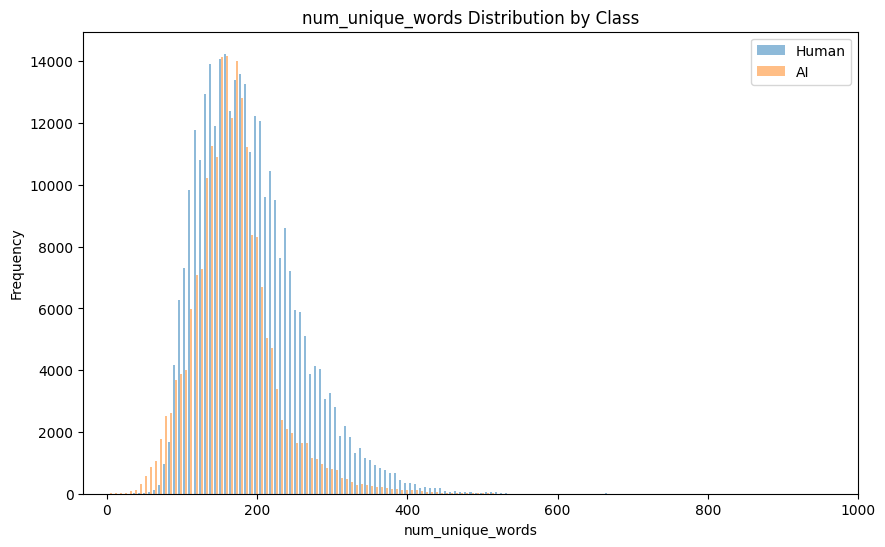

In [38]:
plt.figure(figsize=(10, 6))
plt.hist([df_vis[df_vis['label'] == 0]['num_unique_words'], df_vis[df_vis['label'] == 1]['num_unique_words']], bins=100, alpha=0.5, label=['Human', 'AI'])
plt.title('num_unique_words Distribution by Class')
plt.xlabel('num_unique_words')
plt.ylabel('Frequency')
plt.xlim(right=1000)
plt.legend()
plt.show()

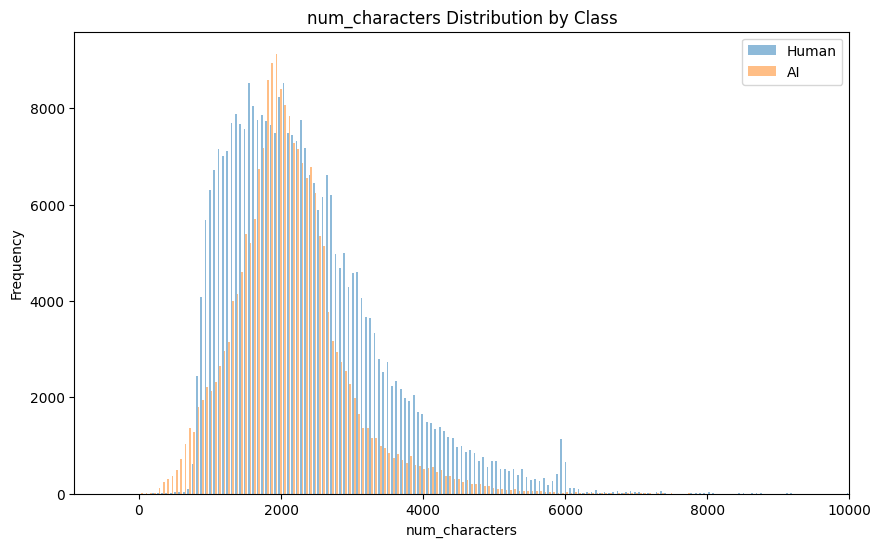

In [39]:
plt.figure(figsize=(10, 6))
plt.hist([df_vis[df_vis['label'] == 0]['num_characters'], df_vis[df_vis['label'] == 1]['num_characters']], bins=300, alpha=0.5, label=['Human', 'AI'])
plt.title('num_characters Distribution by Class')
plt.xlabel('num_characters')
plt.ylabel('Frequency')
plt.xlim(right=10000)
plt.legend()
plt.show()

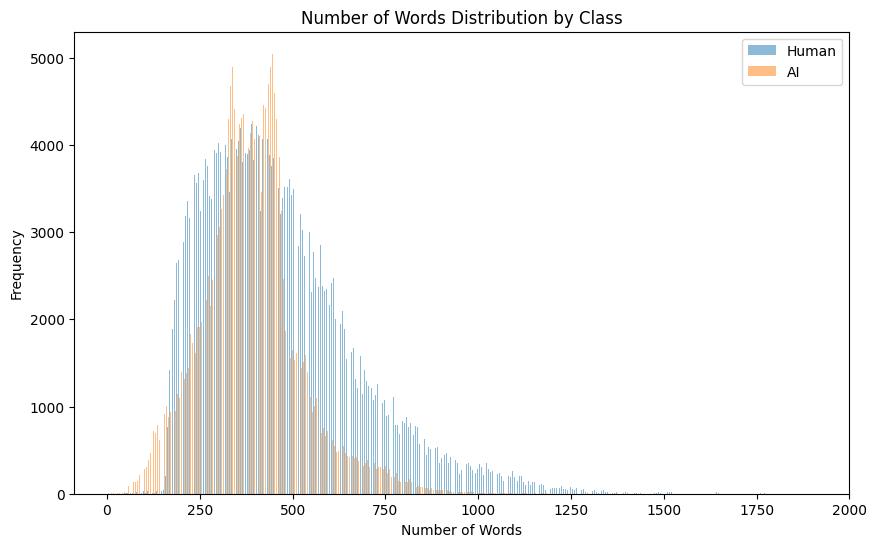

In [40]:
# Plot distribution of number of words
plt.figure(figsize=(10, 6))
plt.hist([df_vis[df_vis['label'] == 0]['num_words'], df_vis[df_vis['label'] == 1]['num_words']], bins=300, alpha=0.5, label=['Human', 'AI'])
plt.title('Number of Words Distribution by Class')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(right=2000)
plt.legend()
plt.show()

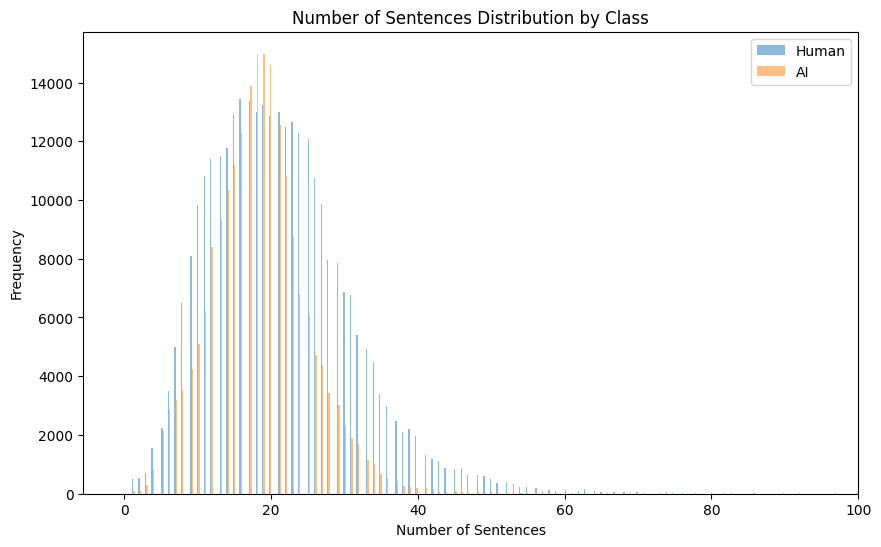

In [41]:
# Plot distribution of number of sentences
plt.figure(figsize=(10, 6))
plt.hist([df_vis[df_vis['label'] == 0]['num_sentences'], df_vis[df_vis['label'] == 1]['num_sentences']], bins=300, alpha=0.5, label=['Human', 'AI'])
plt.title('Number of Sentences Distribution by Class')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.xlim(right=100)
plt.legend()
plt.show()

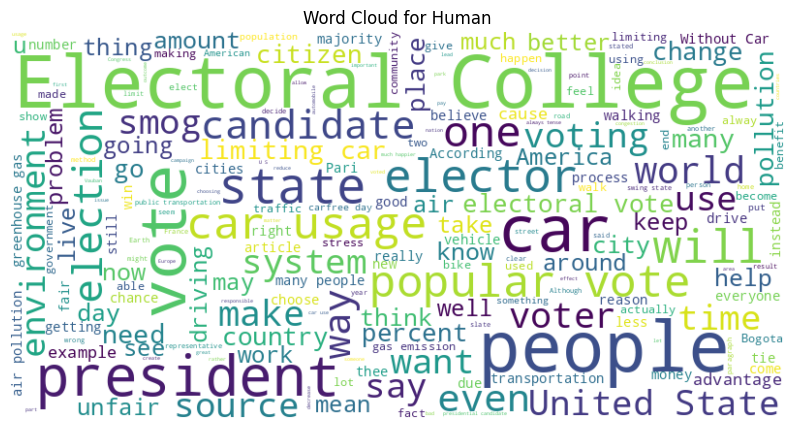

In [23]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_org[df_org['generated'] == 0]['text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Human')
plt.axis('off')
plt.show()

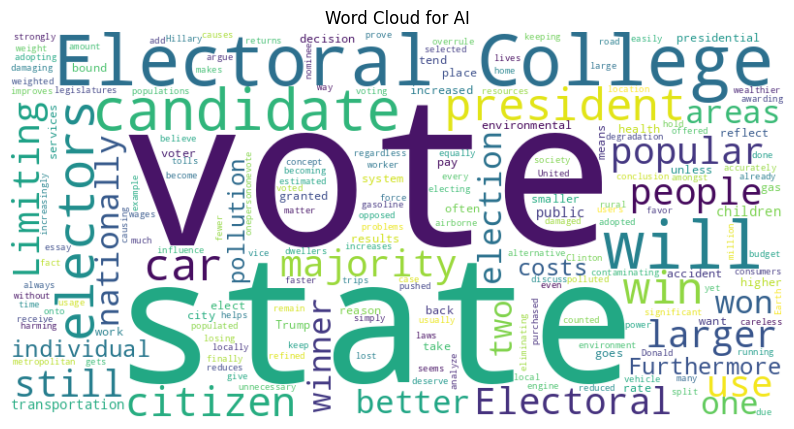

In [24]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_org[df_org['generated'] == 1]['text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for AI')
plt.axis('off')
plt.show()

In [21]:
data = aggregated_train.copy()

In [27]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527720 entries, 0 to 527719
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   prompt_id  527720 non-null  object 
 1   text       527720 non-null  object 
 2   label      527720 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.1+ MB
None


In [28]:
print(data.describe())

               label
count  527720.000000
mean        0.398871
std         0.489667
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


In [29]:
print(data['label'].value_counts())

label
0.0    317228
1.0    210492
Name: count, dtype: int64


In [22]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [23]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
# Download WordNet using NLTK Downloader
!python3 -m nltk.downloader wordnet
!echo 'yes' | unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpor

In [25]:
# Apply tqdm to pandas
tqdm.pandas()

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization - sentence and word
    sentences = sent_tokenize(text)
    tokens = [word_tokenize(sentence) for sentence in sentences]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [[word for word in sentence if word not in stop_words] for sentence in tokens]

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in tokens]

    # Rejoin tokens into processed text
    processed_text = [' '.join(sentence) for sentence in tokens]

    return processed_text

In [26]:
# Apply text preprocessing to 'text' column with tqdm
tqdm.pandas(desc="Processing")
data['text'] = data['text'].progress_apply(preprocess_text)

Processing: 100%|██████████| 527720/527720 [44:06<00:00, 199.42it/s] 


In [27]:
data

,prompt_id,text,label
0,0,[car car around since became famous henry ford...,0.0
1,0,[transportation large necessity country worldw...,0.0
2,0,[america love affair vehicle seems cooling say...,0.0
3,0,[often ride car drive one motor vehicle work s...,0.0
4,0,[car wonderful thing perhaps one world greates...,0.0
...,...,...,...
527715,Grades for extracurricular activities,[writing today disagree taking action innocenc...,1.0
527716,Grades for extracurricular activities,[dear principal conclusion would observe altho...,1.0
527717,Grades for extracurricular activities,[dear mr principal kind consideration taken co...,1.0
527718,Grades for extracurricular activities,[enjoyed form five excitedly ex claim educatio...,1.0


In [60]:
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [29]:
# Combine the processed text into a single string for TF-IDF vectorization
data['processed_text_combined'] = data['text'].apply(lambda x: ' '.join(x))

# # TF-IDF vectorization
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# X_tfidf = tfidf_vectorizer.fit_transform(data['processed_text_combined']).toarray()

In [ ]:
# X_tfidf

In [30]:
data.head()

,prompt_id,text,label,processed_text_combined
0,0,[car car around since became famous henry ford...,0.0,car car around since became famous henry ford ...
1,0,[transportation large necessity country worldw...,0.0,transportation large necessity country worldwi...
2,0,[america love affair vehicle seems cooling say...,0.0,america love affair vehicle seems cooling say ...
3,0,[often ride car drive one motor vehicle work s...,0.0,often ride car drive one motor vehicle work st...
4,0,[car wonderful thing perhaps one world greates...,0.0,car wonderful thing perhaps one world greatest...


In [31]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchtext

In [33]:
# Build vocabulary
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
all_texts = list(train_data['processed_text_combined']) + list(test_data['processed_text_combined'])
vocab = torchtext.vocab.build_vocab_from_iterator(map(tokenizer, all_texts))

In [34]:
len(vocab)

292685

In [35]:
# Convert processed text to sequences of indices
train_sequences = [torch.tensor([vocab[token] for token in tokenizer(text)]) for text in train_data['processed_text_combined']]
test_sequences = [torch.tensor([vocab[token] for token in tokenizer(text)]) for text in test_data['processed_text_combined']]

In [36]:
max_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

In [37]:
import torch.nn.functional as F

In [38]:
# Pad sequences to the maximum length
X_train = torch.nn.utils.rnn.pad_sequence([F.pad(seq, (0, max_len - len(seq))) for seq in train_sequences], batch_first=True)
X_test = torch.nn.utils.rnn.pad_sequence([F.pad(seq, (0, max_len - len(seq))) for seq in test_sequences], batch_first=True)

In [39]:
# Convert labels to tensors
y_train = torch.tensor(train_data['label'].values, dtype=torch.float32)
y_test = torch.tensor(test_data['label'].values, dtype=torch.float32)

In [40]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [77]:
import torch.nn as nn

class AutoencoderClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, encoding_size):
        super(AutoencoderClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoding_size = encoding_size
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size, self.encoding_size),
            nn.BatchNorm1d(self.encoding_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size, self.input_size),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.encoding_size, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32, self.output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Ensure x has the same dtype as the encoder weights
        x = x.to(self.encoder[0].weight.dtype)

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # Convert encoded to the same dtype as classifier weights
        encoded = encoded.to(self.classifier[0].weight.dtype)

        # Explicitly cast the output of the classifier to Float
        classification = self.classifier(encoded).float()

        return decoded, classification

In [78]:
# Assuming your DataLoader is named 'train_loader'
for batch in train_loader:
    # Printing the shape of each element in the batch
    for element in batch:
        print(element.shape)
        break
    break

torch.Size([64, 931])


In [79]:
# Initialize model
input_size = 931
hidden_size = 512
output_size = 1
encoding_size = 256
# Instantiate the model
model = AutoencoderClassifier(input_size, hidden_size, output_size, encoding_size)

In [80]:
input_size

931

In [81]:
# Define loss functions
criterion_ae = nn.MSELoss()
criterion_classifier = nn.BCELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [83]:
def train_model(model, train_loader, criterion_ae, criterion_classifier, optimizer, num_epochs=5):
    all_losses_ae = []
    all_losses_classifier = []
    all_f1_scores = []
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_aurocs = []
    all_auprcs = []

    for epoch in range(num_epochs):
        # Wrap the train_loader with tqdm for a progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as t:
            epoch_losses_ae = []
            epoch_losses_classifier = []

            for inputs, labels in t:
                inputs = inputs.float()
                outputs_ae, outputs_classifier = model(inputs)

                # Loss for the autoencoder
                loss_ae = criterion_ae(outputs_ae, inputs)
                # Loss for the classifier
                loss_classifier = criterion_classifier(outputs_classifier.squeeze(), labels)

                # Total loss is the sum of the autoencoder and classifier losses
                loss_total = 0.000001*loss_ae + loss_classifier

                optimizer.zero_grad()
                loss_total.backward()
                optimizer.step()

                epoch_losses_ae.append(loss_ae.item())
                epoch_losses_classifier.append(loss_classifier.item())

                # Update the progress bar description with the current loss
                t.set_postfix(loss_ae=0.000001*loss_ae.item(), loss_classifier=loss_classifier.item())

            # Calculate metrics for the epoch
            all_losses_ae.append(np.mean(epoch_losses_ae))
            all_losses_classifier.append(np.mean(epoch_losses_classifier))

            y_true, y_pred = evaluate_model(model, train_loader)
            f1 = f1_score(y_true, y_pred)
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            auroc = roc_auc_score(y_true, y_pred)
            auprc = average_precision_score(y_true, y_pred)

            # Store metrics for plotting
            all_f1_scores.append(f1)
            all_accuracies.append(accuracy)
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_aurocs.append(auroc)
            all_auprcs.append(auprc)

            # Update the progress bar description with metrics
            print(f"Epoch {epoch + 1}/{num_epochs} - "
                  f"Loss AE: {np.mean(epoch_losses_ae):.4f}, "
                  f"Loss Classifier: {np.mean(epoch_losses_classifier):.4f}, "
                  f"F1: {f1:.4f}, "
                  f"Accuracy: {accuracy:.4f}, "
                  f"Precision: {precision:.4f}, "
                  f"Recall: {recall:.4f}, "
                  f"AUROC: {auroc:.4f}, "
                  f"AUPRC: {auprc:.4f}")

    # Plotting
    plot_metrics(num_epochs, all_losses_ae, all_losses_classifier, all_f1_scores, all_accuracies,
                 all_precisions, all_recalls, all_aurocs, all_auprcs)

In [84]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.float()
            outputs_ae, outputs_classifier = model(inputs)
            predictions = ( outputs_classifier > 0.5).float()
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions.numpy())

    model.train()
    return np.array(all_labels), np.array(all_predictions)

In [41]:
def plot_metrics(num_epochs, losses_ae, losses_classifier, f1_scores, accuracies, precisions, recalls, aurocs, auprcs):
    plt.figure(figsize=(15, 10))

    # Plot Loss AE
    plt.subplot(2, 3, 1)
    plt.plot(range(1, num_epochs + 1), losses_ae, label='Loss AE')
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss AE')
    plt.legend()

    # Plot Loss Classifier
    plt.subplot(2, 3, 1)
    plt.plot(range(1, num_epochs + 1), losses_classifier, label='Loss Classifier')
    plt.title('Classifier Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Classifier')
    plt.legend()

    # Plot F1 Score
    plt.subplot(2, 3, 2)
    plt.plot(range(1, num_epochs + 1), f1_scores, label='F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 3, 3)
    plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Precision
    plt.subplot(2, 3, 4)
    plt.plot(range(1, num_epochs + 1), precisions, label='Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Recall
    plt.subplot(2, 3, 5)
    plt.plot(range(1, num_epochs + 1), recalls, label='Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # Plot AUROC
    plt.subplot(2, 3, 6)
    plt.plot(range(1, num_epochs + 1), aurocs, label='AUROC')
    plt.title('AUROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/5: 100%|██████████| 6597/6597 [01:19<00:00, 83.21batch/s, loss_ae=26.9, loss_classifier=0.561]


Epoch 1/5 - Loss AE: 22004944.9548, Loss Classifier: 0.6109, F1: 0.6077, Accuracy: 0.5994, Precision: 0.4989, Recall: 0.7772, AUROC: 0.6293, AUPRC: 0.4767


Epoch 2/5: 100%|██████████| 6597/6597 [01:20<00:00, 82.43batch/s, loss_ae=8.87, loss_classifier=0.535]


Epoch 2/5 - Loss AE: 22003579.7749, Loss Classifier: 0.5859, F1: 0.6095, Accuracy: 0.5889, Precision: 0.4909, Recall: 0.8037, AUROC: 0.6250, AUPRC: 0.4729


Epoch 3/5: 100%|██████████| 6597/6597 [01:18<00:00, 83.97batch/s, loss_ae=20, loss_classifier=0.513]  


Epoch 3/5 - Loss AE: 22004423.7740, Loss Classifier: 0.5743, F1: 0.6178, Accuracy: 0.6009, Precision: 0.5001, Recall: 0.8080, AUROC: 0.6357, AUPRC: 0.4807


Epoch 4/5: 100%|██████████| 6597/6597 [01:19<00:00, 82.79batch/s, loss_ae=23.1, loss_classifier=0.646]


Epoch 4/5 - Loss AE: 22004658.4610, Loss Classifier: 0.5660, F1: 0.6394, Accuracy: 0.6463, Precision: 0.5391, Recall: 0.7855, AUROC: 0.6697, AUPRC: 0.5091


Epoch 5/5: 100%|██████████| 6597/6597 [01:23<00:00, 79.22batch/s, loss_ae=18.4, loss_classifier=0.445]


Epoch 5/5 - Loss AE: 22004301.0520, Loss Classifier: 0.5589, F1: 0.6222, Accuracy: 0.5968, Precision: 0.4970, Recall: 0.8318, AUROC: 0.6362, AUPRC: 0.4805


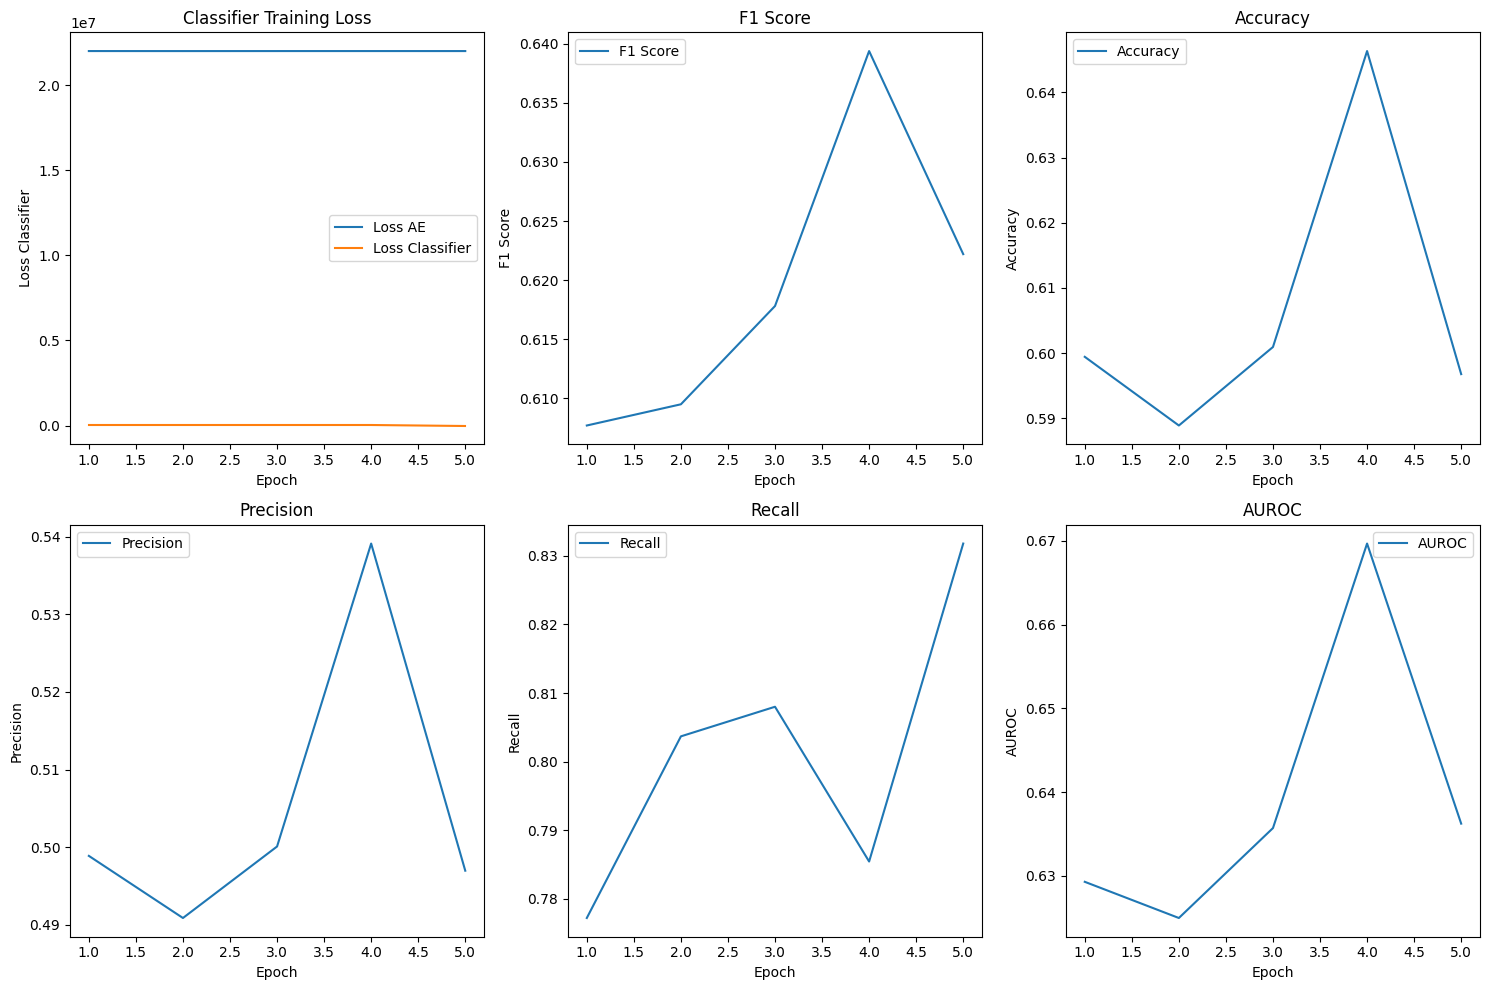

In [87]:
train_model(model, train_loader, criterion_ae, criterion_classifier, optimizer, num_epochs=5)

In [86]:
X_test[0].shape

torch.Size([931])

In [94]:
def evaluate_model(model, X_test, test_data):
    model.eval()
    with torch.no_grad():
        inputs = X_test.float()
        ae_outputs, clss_outputs = model(inputs)
        predictions = (clss_outputs > 0.5).float()
        all_labels = test_data['label'].values
        all_predictions = predictions.numpy()

    model.train()
    return all_labels, all_predictions


In [95]:
all_labels, all_predictions = evaluate_model(model, X_test, test_data)

In [96]:
roc_auc_nn = roc_auc_score(all_labels, all_predictions)
print(f"ROC-AUC (PyTorch NN): {roc_auc_nn}")

ROC-AUC (PyTorch NN): 0.6248574514555735


In [42]:
class SimpleLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, num_labels):
        super(SimpleLSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, num_labels),
            nn.Sigmoid()
        )

    def forward(self, input_ids):
        # Input embedding
        embedded_input = self.embedding(input_ids)

        # LSTM layer
        lstm_output, _ = self.lstm(embedded_input)

        # Pooling or taking the output of the last LSTM layer (you can modify this based on your task)
        last_hidden_state = lstm_output[:, -1, :]

        # Classifier head
        logits = self.classifier(last_hidden_state)

        return logits

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, inputs):
        attn_output, _ = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, sequence_length):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 32, bidirectional=True, batch_first=True)
        self.transformer_block = TransformerBlock(64, 2, 32)
        self.conv1d = nn.Conv1d(64, 128, kernel_size=7, padding=0, stride=3)
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        self.dense1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.embedding(inputs)
        x, _ = self.lstm(x)
        x = self.transformer_block(x)
        x = x.permute(0, 2, 1)  # Adjust for Conv1D input
        x = self.conv1d(x)
        x = self.global_maxpool(x).squeeze(2)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return self.sigmoid(x)

In [44]:
vocab_size = len(vocab)
sequence_length = 931
embedding_size = 64
hidden_size = 16
num_layers = 2
num_labels = 1  

In [45]:
trf_model = TransformerModel(vocab_size, embedding_size, sequence_length)

In [46]:
model = SimpleLSTMClassifier(vocab_size, embedding_size, hidden_size, num_layers, num_labels)

In [47]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
import numpy as np

In [48]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    all_losses = []
    all_f1_scores = []
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_aurocs = []
    all_auprcs = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        # Wrap the train_loader with tqdm for a progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as t:
            for inputs, labels in t:
                optimizer.zero_grad()

                # Assuming your inputs are sequences of integers (token IDs)
                outputs = model(inputs)

                # Loss
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())

                # Update the progress bar description with the current loss
                t.set_postfix(loss=np.mean(epoch_losses))

        # Calculate metrics for the epoch
        all_losses.append(np.mean(epoch_losses))

        # Evaluate on the training set
        y_true, y_pred = evaluate_model(model, train_loader)
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        auroc = roc_auc_score(y_true, y_pred)
        auprc = average_precision_score(y_true, y_pred)

        # Store metrics for plotting
        all_f1_scores.append(f1)
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_aurocs.append(auroc)
        all_auprcs.append(auprc)

        # Update the progress bar description with metrics
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Loss: {np.mean(epoch_losses):.4f}, "
              f"F1: {f1:.4f}, "
              f"Accuracy: {accuracy:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"AUROC: {auroc:.4f}, "
              f"AUPRC: {auprc:.4f}")

    # Plotting
    plot_metrics(num_epochs, all_losses, all_f1_scores, all_accuracies,
                 all_precisions, all_recalls, all_aurocs, all_auprcs)

In [49]:
def evaluate_model(model, dataloader):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            # Assuming your inputs are sequences of integers (token IDs)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(predictions.cpu().numpy())

    return all_true_labels, all_pred_labels

In [50]:
def plot_metrics(num_epochs, all_losses, f1_scores, accuracies, precisions, recalls, aurocs, auprcs):
    plt.figure(figsize=(15, 10))

    # Plot Loss AE
    plt.subplot(2, 3, 1)
    plt.plot(range(1, num_epochs + 1), all_losses, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    # Plot F1 Score
    plt.subplot(2, 3, 2)
    plt.plot(range(1, num_epochs + 1), f1_scores, label='F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 3, 3)
    plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Precision
    plt.subplot(2, 3, 4)
    plt.plot(range(1, num_epochs + 1), precisions, label='Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Recall
    plt.subplot(2, 3, 5)
    plt.plot(range(1, num_epochs + 1), recalls, label='Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # Plot AUROC
    plt.subplot(2, 3, 6)
    plt.plot(range(1, num_epochs + 1), aurocs, label='AUROC')
    plt.title('AUROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [51]:
# Define your loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
# Call the training loop
train_model(trf_model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5:  15%|█▍        | 957/6597 [06:59<41:20,  2.27batch/s, loss=0.692]

#### ML part

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve

In [34]:
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your dataset
X_train_tfidf = vectorizer.fit_transform(train_data['processed_text_combined'])
X_test_tfidf = vectorizer.transform(test_data['processed_text_combined'])

In [33]:
# Step 3: Choose a model (Support Vector Machine)
svm_model = SVC(probability=True)  # Use probability=True to get ROC-AUC scores

In [ ]:
# Step 3: Train the model
svm_model.fit(X_train_tfidf, train_data['label'])

In [ ]:
# Step 4: Evaluate the model
y_prob_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]  # Probability estimates for the positive class
roc_auc_svm = roc_auc_score(test_data['label'], y_prob_svm)

In [ ]:
print("ROC-AUC (SVM):", roc_auc_svm)
print("Classification Report (SVM):\n", classification_report(test_data['label'], svm_model.predict(X_test_tfidf)))

In [35]:
# Additional classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

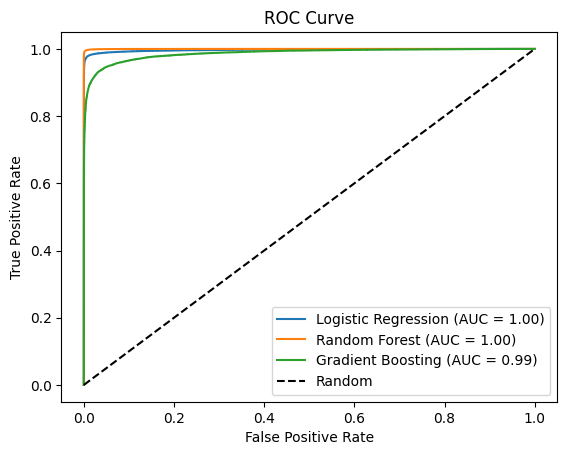

In [36]:
# Train and evaluate additional classifiers
roc_auc_scores = {}

for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, train_data['label'])
    y_prob = clf.predict_proba(X_test_tfidf)[:, 1]
    roc_auc = roc_auc_score(test_data['label'], y_prob)
    roc_auc_scores[name] = roc_auc
    fpr, tpr, _ = roc_curve(test_data['label'], y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [37]:
# Display ROC-AUC scores for all classifiers
print("ROC-AUC Scores:")
for name, roc_auc in roc_auc_scores.items():
    print(f"{name}: {roc_auc:.4f}")

ROC-AUC Scores:
Logistic Regression: 0.9971
Random Forest: 0.9999
Gradient Boosting: 0.9868
